In [ ]:
#If necessary:
#pip install pyldavis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# load the libraries

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
# Load preprocesing libraries

import nltk
from nltk.tokenize import word_tokenize,TweetTokenizer
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import string


import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Set some seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(2)
tf.keras.utils.set_random_seed(10)
tf.config.experimental.enable_op_determinism()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Load the predicted negative reviews dataset (obtained with sentiment analysis)

df = pd.read_csv("/content/pred_negative_reviews.csv", encoding='latin1')
print(df.head(4))

                                     Negative review
0  somehow forgot give u order big deal needed ex...
1  went drive-through ordered double mac meal rec...
2  terrible employee name  ha worse customer serv...
3                            closed supposed 24 hour


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Convert them into a list

pred_negative_reviews = df['Negative review'].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Preprocessing for LDA**

In [ ]:
#Our input data is a list of predicted negative reviews obtained by sentiment analysis
print('Number of negative reviews',len(pred_negative_reviews))
print(pred_negative_reviews[:2])

Number of negative reviews 4186
['somehow forgot give u order big deal needed exercise apologize', 'went drive-through ordered double mac meal received single mac meal food wa cold drove away call back told meal wa wrong manager tell next visit receive complimentary order giving right order given money back gave mcdonald benefit benefit doubt 1st bad experience mcdonald last never visit mcdonald']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Normalization
review_list = [review.lower() for review in pred_negative_reviews]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Tokenization
rev_words = [[word for word in review.split()] for review in review_list]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# POS tagging using NLTK pos tagger
pos_tagged_review = [pos_tag(review) for review in rev_words]
print(len(pos_tagged_review))
print(pos_tagged_review[:5])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4186
[[('somehow', 'RB'), ('forgot', 'JJ'), ('give', 'VBP'), ('u', 'JJ'), ('order', 'NN'), ('big', 'JJ'), ('deal', 'NN'), ('needed', 'VBN'), ('exercise', 'NN'), ('apologize', 'NN')], [('went', 'VBD'), ('drive-through', 'JJ'), ('ordered', 'VBN'), ('double', 'JJ'), ('mac', 'NN'), ('meal', 'NN'), ('received', 'VBD'), ('single', 'JJ'), ('mac', 'NN'), ('meal', 'NN'), ('food', 'NN'), ('wa', 'NN'), ('cold', 'VBD'), ('drove', 'VB'), ('away', 'RB'), ('call', 'VB'), ('back', 'RB'), ('told', 'JJ'), ('meal', 'NN'), ('wa', 'NN'), ('wrong', 'JJ'), ('manager', 'NN'), ('tell', 'VBP'), ('next', 'IN'), ('visit', 'NN'), ('receive', 'VBP'), ('complimentary', 'JJ'), ('order', 'NN'), ('giving', 'VBG'), ('right', 'JJ'), ('order', 'NN'), ('given', 'VBN'), ('money', 'NN'), ('back', 'RB'), ('gave', 'VBD'), ('mcdonald', 'NNP'), ('benefit', 'NN'), ('benefit', 'NN'), ('doubt', 'NN'), ('1st', 'CD'), ('bad', 'JJ'), ('experience', 'NN'), ('mcdonald', 'NN'), ('last', 'JJ'), ('never', 'RB'), ('visit', 'VBP'), ('mcdonal

In [ ]:
# Limit the data to only terms with noun tags: for the topic model, we should want to include only nouns and adjectives.
pos_noun_reviews = []
for review in pos_tagged_review:
    nouns=[]
    for word_tuple in review:
        if ("NN" in word_tuple[1] or "JJ" in word_tuple[1]):
            nouns.append(word_tuple)
    pos_noun_reviews.append(nouns)

print(pos_noun_reviews[:5])

[[('forgot', 'JJ'), ('u', 'JJ'), ('order', 'NN'), ('big', 'JJ'), ('deal', 'NN'), ('exercise', 'NN'), ('apologize', 'NN')], [('drive-through', 'JJ'), ('double', 'JJ'), ('mac', 'NN'), ('meal', 'NN'), ('single', 'JJ'), ('mac', 'NN'), ('meal', 'NN'), ('food', 'NN'), ('wa', 'NN'), ('told', 'JJ'), ('meal', 'NN'), ('wa', 'NN'), ('wrong', 'JJ'), ('manager', 'NN'), ('visit', 'NN'), ('complimentary', 'JJ'), ('order', 'NN'), ('right', 'JJ'), ('order', 'NN'), ('money', 'NN'), ('mcdonald', 'NNP'), ('benefit', 'NN'), ('benefit', 'NN'), ('doubt', 'NN'), ('bad', 'JJ'), ('experience', 'NN'), ('mcdonald', 'NN'), ('last', 'JJ'), ('mcdonald', 'NNS')], [('terrible', 'JJ'), ('employee', 'NN'), ('name', 'NN'), ('ha', 'NN'), ('worse', 'JJR'), ('customer', 'NN'), ('service', 'NN'), ('order', 'NN'), ('wa', 'NN'), ('wrong', 'JJ'), ('hard', 'JJ'), ('time', 'NN'), ('fix', 'JJ'), ('bad', 'JJ'), ('service', 'NN')], [('hour', 'NN')], [('service', 'NN'), ('slow', 'JJ'), ('minute', 'NN'), ('egg', 'NN'), ('mcmuffin', 'N

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Discard empty reviews
pos_noun_reviews=[review for review in pos_noun_reviews if len(review)>=1]
print(len(pos_noun_reviews), pos_noun_reviews[:5])

4143 [[('forgot', 'JJ'), ('u', 'JJ'), ('order', 'NN'), ('big', 'JJ'), ('deal', 'NN'), ('exercise', 'NN'), ('apologize', 'NN')], [('drive-through', 'JJ'), ('double', 'JJ'), ('mac', 'NN'), ('meal', 'NN'), ('single', 'JJ'), ('mac', 'NN'), ('meal', 'NN'), ('food', 'NN'), ('wa', 'NN'), ('told', 'JJ'), ('meal', 'NN'), ('wa', 'NN'), ('wrong', 'JJ'), ('manager', 'NN'), ('visit', 'NN'), ('complimentary', 'JJ'), ('order', 'NN'), ('right', 'JJ'), ('order', 'NN'), ('money', 'NN'), ('mcdonald', 'NNP'), ('benefit', 'NN'), ('benefit', 'NN'), ('doubt', 'NN'), ('bad', 'JJ'), ('experience', 'NN'), ('mcdonald', 'NN'), ('last', 'JJ'), ('mcdonald', 'NNS')], [('terrible', 'JJ'), ('employee', 'NN'), ('name', 'NN'), ('ha', 'NN'), ('worse', 'JJR'), ('customer', 'NN'), ('service', 'NN'), ('order', 'NN'), ('wa', 'NN'), ('wrong', 'JJ'), ('hard', 'JJ'), ('time', 'NN'), ('fix', 'JJ'), ('bad', 'JJ'), ('service', 'NN')], [('hour', 'NN')], [('service', 'NN'), ('slow', 'JJ'), ('minute', 'NN'), ('egg', 'NN'), ('mcmuffin

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Lemmatization
wnl = WordNetLemmatizer()
lemmatized_words =[]
for review in pos_noun_reviews:
    lemma_word=[]
    for word in review:
        lemma_word.append(wnl.lemmatize(word[0]))
    lemmatized_words.append(lemma_word)

print(lemmatized_words[:5])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['forgot', 'u', 'order', 'big', 'deal', 'exercise', 'apologize'], ['drive-through', 'double', 'mac', 'meal', 'single', 'mac', 'meal', 'food', 'wa', 'told', 'meal', 'wa', 'wrong', 'manager', 'visit', 'complimentary', 'order', 'right', 'order', 'money', 'mcdonald', 'benefit', 'benefit', 'doubt', 'bad', 'experience', 'mcdonald', 'last', 'mcdonald'], ['terrible', 'employee', 'name', 'ha', 'worse', 'customer', 'service', 'order', 'wa', 'wrong', 'hard', 'time', 'fix', 'bad', 'service'], ['hour'], ['service', 'slow', 'minute', 'egg', 'mcmuffin', 'apology', 'long', 'delay']]


In [ ]:
# Remove stopwords and punctuations

tweet_tokenize = TweetTokenizer()

#Create list of stopwords with punctuations and manually add characters we want to eliminate
stop_words = stopwords.words("english")
stop_words = stop_words+list(string.punctuation)+["\'s", "½", "ï", "¿", '...', '..']

filtered_rev_words=[]

for review in lemmatized_words:
    filter_words=[]
    for words in review:
        rev_words = []
        rev_words = tweet_tokenize.tokenize(words)
        for word in rev_words:
            if word not in stop_words:
                filter_words.append(word)
    filtered_rev_words.append(filter_words)

print('number of reviews:', len(filtered_rev_words))
print("let's see some reviews:", filtered_rev_words[:4])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


number of reviews: 4143
let's see some reviews: [['forgot', 'u', 'order', 'big', 'deal', 'exercise', 'apologize'], ['drive-through', 'double', 'mac', 'meal', 'single', 'mac', 'meal', 'food', 'wa', 'told', 'meal', 'wa', 'wrong', 'manager', 'visit', 'complimentary', 'order', 'right', 'order', 'money', 'mcdonald', 'benefit', 'benefit', 'doubt', 'bad', 'experience', 'mcdonald', 'last', 'mcdonald'], ['terrible', 'employee', 'name', 'ha', 'worse', 'customer', 'service', 'order', 'wa', 'wrong', 'hard', 'time', 'fix', 'bad', 'service'], ['hour']]


In [ ]:
#Discard empty reviews
filtered_rev_words=[review for review in filtered_rev_words if len(review)>=1]
print(len(filtered_rev_words),filtered_rev_words[:10])

4143 [['forgot', 'u', 'order', 'big', 'deal', 'exercise', 'apologize'], ['drive-through', 'double', 'mac', 'meal', 'single', 'mac', 'meal', 'food', 'wa', 'told', 'meal', 'wa', 'wrong', 'manager', 'visit', 'complimentary', 'order', 'right', 'order', 'money', 'mcdonald', 'benefit', 'benefit', 'doubt', 'bad', 'experience', 'mcdonald', 'last', 'mcdonald'], ['terrible', 'employee', 'name', 'ha', 'worse', 'customer', 'service', 'order', 'wa', 'wrong', 'hard', 'time', 'fix', 'bad', 'service'], ['hour'], ['service', 'slow', 'minute', 'egg', 'mcmuffin', 'apology', 'long', 'delay'], ['wrong', 'order', 'watch', 'double', 'order', 'lane', 'mean', 'double', 'mistake'], ['wish', 'place', 'star', 'computer', 'time', 'service', 'ha', 'last', 'year', 'hour', 'employee', 'zombie', 'slow', 'whats', 'place', 'trash', 'customer', 'service', 'good', 'talk', 'night', 'manager', 'mcdonald', 'part', 'service', 'industry', 'mcdonald', 'friend', 'foot'], ['place', 'full', 'kid', 'employee', 'body', 'care', 'cust

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


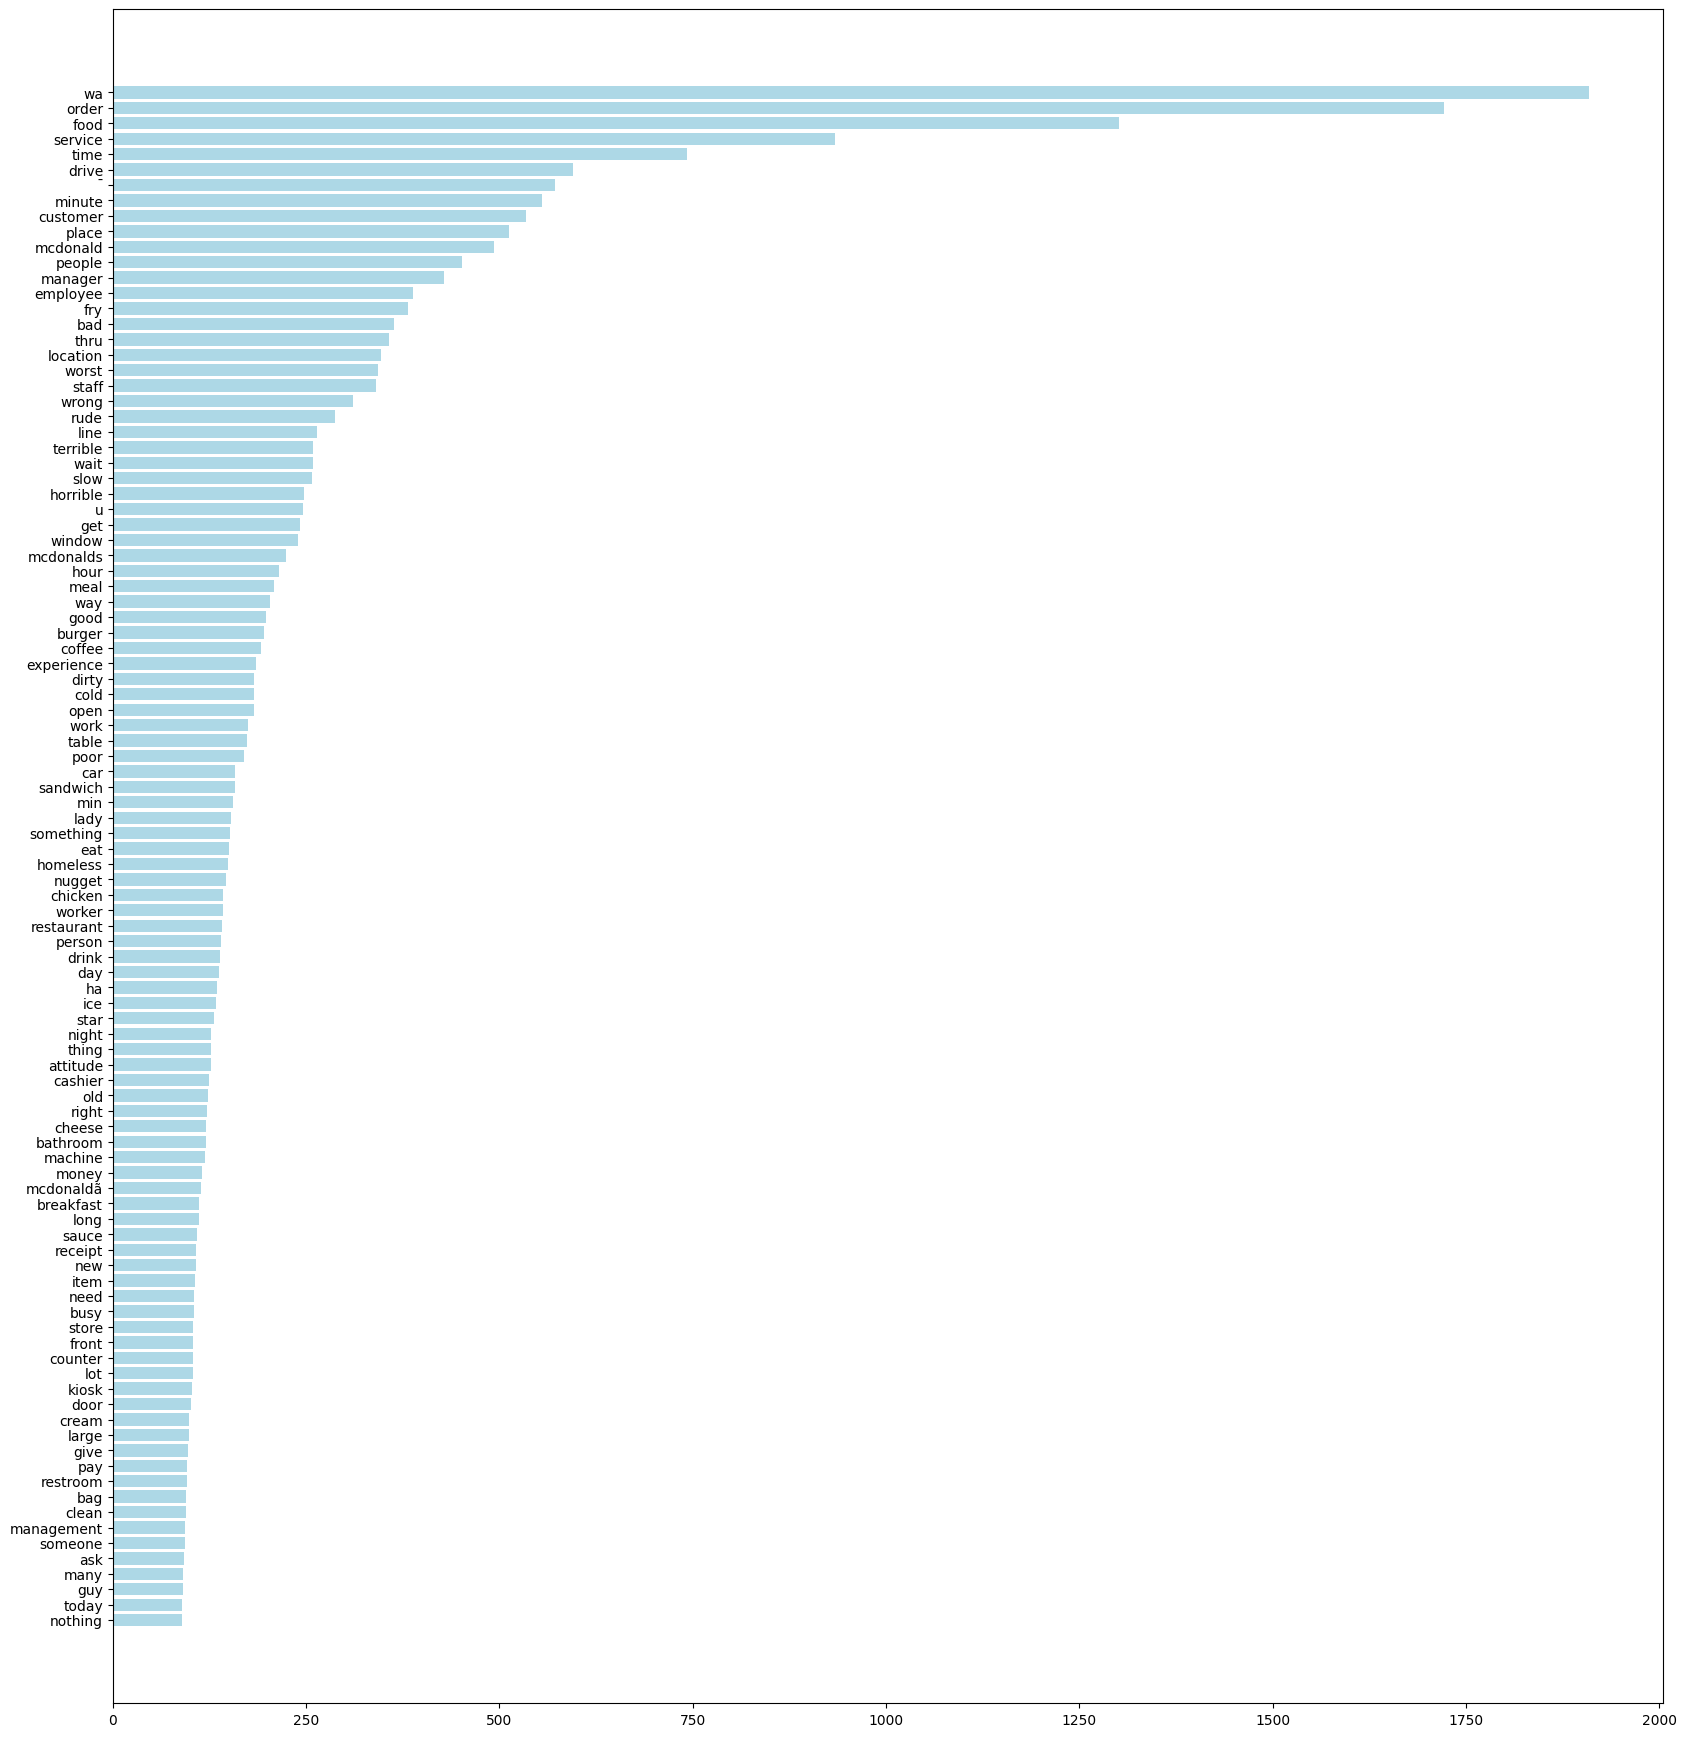

In [ ]:
# Barplot to visualize the 100 most common words using FreqDist and barplots
list_of_words = [word for review in filtered_rev_words for word in review]
common_word_freq=FreqDist(list_of_words).most_common(100)
word_list = common_word_freq[::-1]

words,freq = [],[]
for word in word_list:
    words.append(word[0])
    freq.append(word[1])
x=np.array(words)
y=np.array(freq)

plt.figure(figsize=(20,22))
plt.barh(x,y,color="lightblue")
plt.show()

In [ ]:
#Most common words
print(common_word_freq)

[('wa', 1909), ('order', 1721), ('food', 1301), ('service', 934), ('time', 743), ('drive', 595), ('¯', 572), ('minute', 555), ('customer', 534), ('place', 512), ('mcdonald', 493), ('people', 452), ('manager', 428), ('employee', 388), ('fry', 382), ('bad', 364), ('thru', 357), ('location', 347), ('worst', 343), ('staff', 340), ('wrong', 310), ('rude', 287), ('line', 264), ('terrible', 259), ('wait', 259), ('slow', 257), ('horrible', 247), ('u', 246), ('get', 242), ('window', 240), ('mcdonalds', 224), ('hour', 215), ('meal', 208), ('way', 203), ('good', 198), ('burger', 195), ('coffee', 192), ('experience', 185), ('dirty', 182), ('cold', 182), ('open', 182), ('work', 175), ('table', 174), ('poor', 169), ('car', 158), ('sandwich', 158), ('min', 155), ('lady', 153), ('something', 151), ('eat', 150), ('homeless', 149), ('nugget', 146), ('chicken', 142), ('worker', 142), ('restaurant', 141), ('person', 140), ('drink', 138), ('day', 137), ('ha', 135), ('ice', 133), ('star', 131), ('night', 12

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Revising the stopwords based of above analysis
#We remove the following words (not useful for our analysys)
#Exclusion of terms that are too common, which may be less informative to distinguish between different topics

stop_words_inclusions = ['mcdonald', 'mcdonalds', 'mcdonaldï', 'iï', 'donï', 'didnï', 'wa', 'way', 'u', 'get', 'something', 'ha', 'eat', 'thru', 'mcdonaldã',
                         'donã', 'iã', 'order', 'food', 'service']
stop_words = stop_words + stop_words_inclusions


#isalnum() to remove emoji an isnumeric() to remove only number tokens present in the list
#len(word)!=1 will eliminate all one letter tokens such as 'u','i' etc.
final_rev_words = []
for review in filtered_rev_words:
    stopwords_removed_review=[]
    for word in review:
        if word not in stop_words and word.isalnum() and (not word.isnumeric()) and len(word)!=1:
            stopwords_removed_review.append(word)
    final_rev_words.append(stopwords_removed_review)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Discard empty reviews
final_rev_words=[review for review in final_rev_words if len(review)>=1]
print(len(final_rev_words),final_rev_words[:50])

4110 [['forgot', 'big', 'deal', 'exercise', 'apologize'], ['double', 'mac', 'meal', 'single', 'mac', 'meal', 'told', 'meal', 'wrong', 'manager', 'visit', 'complimentary', 'right', 'money', 'benefit', 'benefit', 'doubt', 'bad', 'experience', 'last'], ['terrible', 'employee', 'name', 'worse', 'customer', 'wrong', 'hard', 'time', 'fix', 'bad'], ['hour'], ['slow', 'minute', 'egg', 'mcmuffin', 'apology', 'long', 'delay'], ['wrong', 'watch', 'double', 'lane', 'mean', 'double', 'mistake'], ['wish', 'place', 'star', 'computer', 'time', 'last', 'year', 'hour', 'employee', 'zombie', 'slow', 'whats', 'place', 'trash', 'customer', 'good', 'talk', 'night', 'manager', 'part', 'industry', 'friend', 'foot'], ['place', 'full', 'kid', 'employee', 'body', 'care', 'customer', 'free'], ['friendly', 'bad', 'experience', 'dry', 'nugget', 'regret', 'today'], ['employee', 'need', 'customer'], ['usual', 'homeless', 'dnt', 'sanitary', 'norm'], ['cheese', 'mcmuffin', 'nasty'], ['minute', 'drive', 'window', 'terri

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


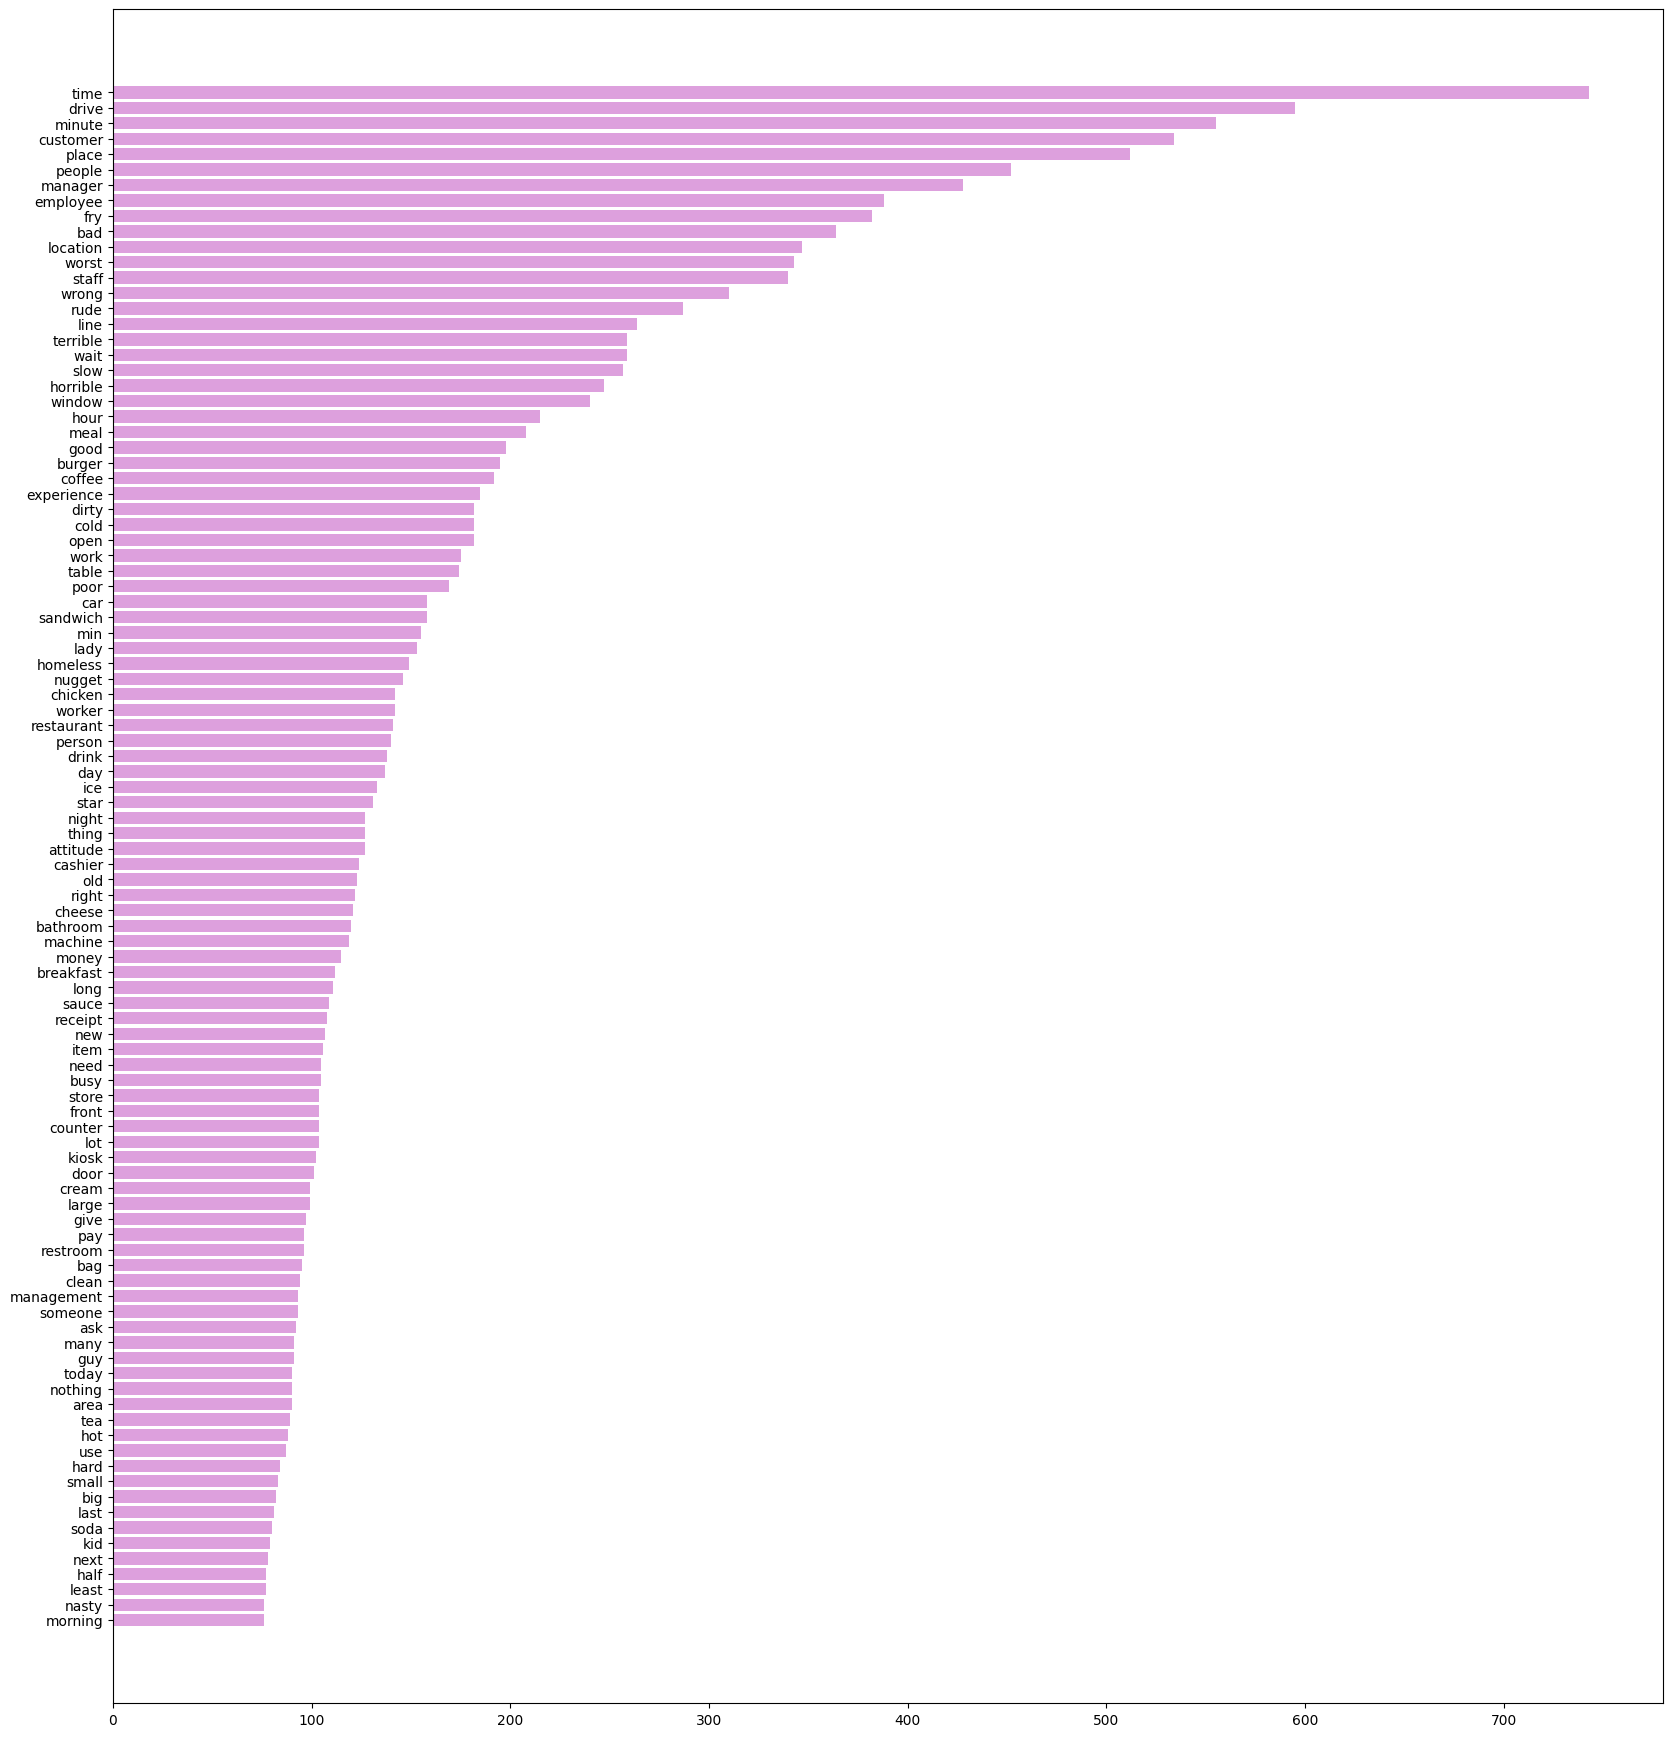

In [ ]:
# Barplot to visualize the 100 most common words using FreqDist and barplots after removing useless words

list_of_words = [word for review in final_rev_words for word in review]
word_freq=FreqDist(list_of_words).most_common(100)
word_list_2 = word_freq[::-1]

words,freq = [],[]
for word in word_list_2:
    words.append(word[0])
    freq.append(word[1])
x=np.array(words)
y=np.array(freq)

plt.figure(figsize=(20,22))
plt.barh(x,y,color="plum")
plt.show()

In [ ]:
print(word_freq[])

[('small', 83), ('big', 82), ('last', 81), ('soda', 80), ('kid', 79), ('next', 78), ('half', 77), ('least', 77), ('nasty', 76), ('morning', 76)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Removal of rare terms, as they may introduce noise into the model.
#Keep only words that occur at least 3 times
n = 3

#count occurencies of single words
counts = Counter(list_of_words)

final_list = [
    [word for word in review if counts[word] >= n]
    for review in final_rev_words
]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(final_list[:2])

[['forgot', 'big', 'deal', 'apologize'], ['double', 'mac', 'meal', 'single', 'mac', 'meal', 'told', 'meal', 'wrong', 'manager', 'visit', 'right', 'money', 'benefit', 'benefit', 'doubt', 'bad', 'experience', 'last']]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Determining the ideal number of topics**

-If this number is too high then the model might fail to detect a topic that is actually broader

-If this number is too low then topics might have large overlapping words.

In [ ]:
# First creating the id2word Dictionary and corpus of words required for the LDA topic model

id2word = corpora.Dictionary(final_list)

corpus =[]
for review in final_list:
    new = id2word.doc2bow(review)
    corpus.append(new)

print(corpus[:20],"\n")
print("No of reviews:",len(corpus),"\n")
print("No of unique words:",len(id2word),"\n")

n_topics = []
coherence_score = []

#LDA models with 2,...,10 topics
for i in range(2,10):
  lda_model_i = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i,
                                           random_state=47,
                                           update_every=1,
                                           chunksize=500,
                                           passes=20,
                                           alpha="auto")

  # Get coherence score
  coherence_model_lda = CoherenceModel(model=lda_model_i, texts=final_list, dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  n_topics.append(i)
  coherence_score.append(coherence_lda)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 1), (1, 1), (2, 1), (3, 1)], [(4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)], [(4, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)], [(27, 1)], [(28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)], [(6, 2), (18, 1), (35, 1), (36, 1), (37, 1), (38, 1)], [(9, 1), (11, 1), (19, 1), (20, 1), (25, 1), (27, 1), (34, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)], [(19, 1), (20, 1), (46, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)], [(4, 1), (8, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1)], [(19, 1), (20, 1), (63, 1)], [(64, 1), (65, 1), (66, 1)], [(32, 1), (67, 1), (68, 1)], [(24, 1), (33, 1), (69, 1), (70, 1)], [(20, 1), (71, 1)], [(18, 1), (25, 1), (31, 1), (69, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83,

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


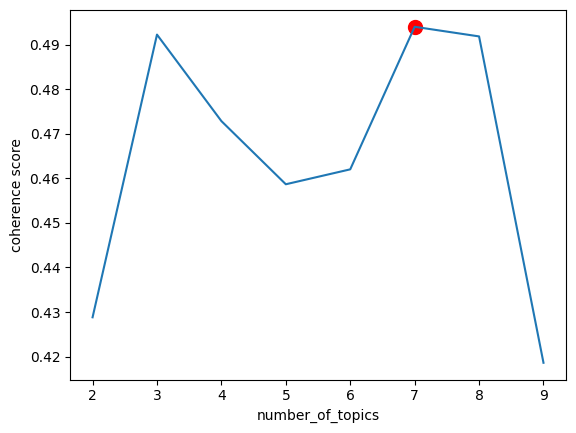

In [ ]:
# Plot the scores
max_score = max(coherence_score)
max_index = coherence_score.index(max_score)
max_n_topic = n_topics[max_index]

plt.plot(n_topics, coherence_score)
plt.scatter(max_n_topic, max_score, color='red', s=100, label=f'Max Score ({max_score})')
plt.xlabel('number_of_topics')
plt.ylabel('coherence score')
plt.show()

The ideal number of topics is 7, as indicated by the plot. However, a model with 3 topics also achieves an acceptable coherence score.

**LDA model**

In [ ]:
# First creating again the id2word Dictionary and corpus of words required for the LDA topic model

id2word = corpora.Dictionary(final_list)

corpus =[]
for review in final_list:
    new = id2word.doc2bow(review)
    corpus.append(new)

print(corpus[:20],"\n")
print("No of reviews:",len(corpus),"\n")
print("No of unique words:",len(id2word),"\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 1), (1, 1), (2, 1), (3, 1)], [(4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)], [(4, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)], [(27, 1)], [(28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)], [(6, 2), (18, 1), (35, 1), (36, 1), (37, 1), (38, 1)], [(9, 1), (11, 1), (19, 1), (20, 1), (25, 1), (27, 1), (34, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)], [(19, 1), (20, 1), (46, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)], [(4, 1), (8, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1)], [(19, 1), (20, 1), (63, 1)], [(64, 1), (65, 1), (66, 1)], [(32, 1), (67, 1), (68, 1)], [(24, 1), (33, 1), (69, 1), (70, 1)], [(20, 1), (71, 1)], [(18, 1), (25, 1), (31, 1), (69, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83,

In [ ]:
#LDA model with 7 topics
n_topics = 7

lda_model_7 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics,
                                           random_state=47,
                                           update_every=1,
                                           chunksize=500,
                                           passes=20,
                                           alpha="auto")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topics=[]
topic_terms=[]
for idx in range(n_topics):
    topics.append("Topic "+ str(idx+1))
    terms=[]
    for term in lda_model_7.get_topic_terms(idx,topn=10):
        terms.append(id2word[term[0]])
    topic_terms.append(terms)

for idx in range(n_topics):
    print(idx,topic_terms[idx])

0 ['time', 'wrong', 'location', 'slow', 'terrible', 'coffee', 'drink', 'bag', 'breakfast', 'cheese']
1 ['bad', 'open', 'cashier', 'lot', 'attention', 'nobody', 'smile', 'fine', 'understand', 'hair']
2 ['fry', 'burger', 'cold', 'meal', 'chicken', 'sandwich', 'large', 'nugget', 'ice', 'small']
3 ['minute', 'drive', 'worst', 'wait', 'line', 'window', 'experience', 'work', 'car', 'min']
4 ['customer', 'employee', 'manager', 'staff', 'rude', 'place', 'horrible', 'poor', 'lady', 'attitude']
5 ['place', 'good', 'hour', 'dirty', 'table', 'night', 'long', 'bathroom', 'store', 'clean']
6 ['people', 'homeless', 'door', 'machine', 'kiosk', 'soda', 'many', 'restaurant', 'area', 'nice']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_topics_7 = pd.DataFrame(topic_terms).transpose()
df_topics_7.columns = topics
df_topics_7

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,time,bad,fry,minute,customer,place,people
1,wrong,open,burger,drive,employee,good,homeless
2,location,cashier,cold,worst,manager,hour,door
3,slow,lot,meal,wait,staff,dirty,machine
4,terrible,attention,chicken,line,rude,table,kiosk
5,coffee,nobody,sandwich,window,place,night,soda
6,drink,smile,large,experience,horrible,long,many
7,bag,fine,nugget,work,poor,bathroom,restaurant
8,breakfast,understand,ice,car,lady,store,area
9,cheese,hair,small,min,attitude,clean,nice


In [ ]:
# coherence of the model with the c_v metric

coherence_model_lda_7 = CoherenceModel(model=lda_model_7, texts=final_list, dictionary=id2word, coherence='c_v')
coherence_lda_7 = coherence_model_lda_7.get_coherence()
print('\nCoherence Score: ', coherence_lda_7)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.4940570919437803


In [ ]:
pyLDAvis.enable_notebook()
vis =pyLDAvis.gensim_models.prepare(lda_model_7,corpus,id2word,mds='mmds',R=25)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.025754 -0.439380       1        1  21.748800
4     -0.393900  0.137595       2        1  19.101889
3      0.293933  0.303666       3        1  16.803903
2      0.413112 -0.148174       4        1  12.870431
6      0.063793 -0.025647       5        1  12.662857
5     -0.309641 -0.215870       6        1  10.999921
1     -0.093051  0.387811       7        1   5.812199, topic_info=          Term        Freq       Total Category  logprob  loglift
25        time  744.000000  744.000000  Default  25.0000  25.0000
4          bad  377.000000  377.000000  Default  24.0000  24.0000
33      minute  595.000000  595.000000  Default  23.0000  23.0000
69       drive  570.000000  570.000000  Default  22.0000  22.0000
94      people  458.000000  458.000000  Default  21.0000  21.0000
...        ...         ...         ...      ...      ...      ...
430     repeat   15.276916   16.104278   Topic7  -4.9332   2.7925
1005     mocha   14.862696   15.690084   Topic7  -4.9607   2.7910
282        lot   83.786295  103.141731   Topic7  -3.2313   2.6374
452     anyone   17.687661   28.847641   Topic7  -4.7867   2.3561
351   business   18.244350   62.856683   Topic7  -4.7557   1.6082

[259 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
788       7  0.960284  acknowledge
684       6  0.965745       answer
452       5  0.346649       anyone
452       7  0.623968       anyone
84        4  0.013306     anything
...     ...       ...          ...
434       2  0.996692       worker
242       4  0.989676        world
170       3  0.997979        worst
18        1  0.996898        wrong
311       2  0.982261        young

[305 rows x 3 columns], R=25, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 3, 7, 6, 2])

Some topics are difficult to interpret, and there is overlap between certain topics. Therefore, we decided to train a model with 3 topics.

In [ ]:
n_topics = 3

lda_model_3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics,
                                           random_state=47,
                                           update_every=1,
                                           chunksize=500,
                                           passes=20,
                                           alpha="auto")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lda_model_3.print_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.046*"time" + 0.037*"minute" + 0.035*"drive" + 0.021*"wrong" + 0.020*"location" + 0.019*"worst" + 0.016*"wait" + 0.015*"slow" + 0.014*"terrible" + 0.014*"horrible"'),
 (1,
  '0.057*"customer" + 0.040*"employee" + 0.040*"manager" + 0.027*"rude" + 0.024*"people" + 0.019*"staff" + 0.015*"lady" + 0.013*"worker" + 0.013*"door" + 0.011*"kiosk"'),
 (2,
  '0.038*"fry" + 0.035*"bad" + 0.029*"place" + 0.020*"people" + 0.017*"good" + 0.016*"open" + 0.015*"dirty" + 0.014*"poor" + 0.014*"cold" + 0.013*"sandwich"')]

In [ ]:
# Top terms for each topic.

topics=[]
topic_terms=[]
for idx in range(n_topics):
    topics.append("Topic "+ str(idx+1))
    terms=[]
    for term in lda_model_3.get_topic_terms(idx,topn=10):
        terms.append(id2word[term[0]])
    topic_terms.append(terms)

for idx in range(n_topics):
    print(idx,topic_terms[idx])

0 ['time', 'minute', 'drive', 'wrong', 'location', 'worst', 'wait', 'slow', 'terrible', 'horrible']
1 ['customer', 'employee', 'manager', 'rude', 'people', 'staff', 'lady', 'worker', 'door', 'kiosk']
2 ['fry', 'bad', 'place', 'people', 'good', 'open', 'dirty', 'poor', 'cold', 'sandwich']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_topics = pd.DataFrame(topic_terms).transpose()
df_topics.columns = topics
df_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 1,Topic 2,Topic 3
0,time,customer,fry
1,minute,employee,bad
2,drive,manager,place
3,wrong,rude,people
4,location,people,good
5,worst,staff,open
6,wait,lady,dirty
7,slow,worker,poor
8,terrible,door,cold
9,horrible,kiosk,sandwich


We give the following names to the topics:

-1: waiting time

-2: staff

-3: physical location and food quality

In [ ]:
# coherence of the model with the c_v metric

coherence_model_lda = CoherenceModel(model=lda_model_3, texts=final_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.4923010079905031


In [ ]:
pyLDAvis.enable_notebook()
vis =pyLDAvis.gensim_models.prepare(lda_model_3,corpus,id2word,mds='mmds',R=25)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.125570  0.283855       1        1  44.212884
2      0.182007 -0.254244       2        1  30.101253
1     -0.307577 -0.029611       3        1  25.685863, topic_info=           Term        Freq       Total Category  logprob  loglift
19     customer  532.000000  532.000000  Default  25.0000  25.0000
25         time  745.000000  745.000000  Default  24.0000  24.0000
20     employee  386.000000  386.000000  Default  23.0000  23.0000
77          fry  414.000000  414.000000  Default  22.0000  22.0000
11      manager  382.000000  382.000000  Default  21.0000  21.0000
..          ...         ...         ...      ...      ...      ...
94       people  220.420419  460.417944   Topic3  -3.7500   0.6226
95       person   81.529801  118.326138   Topic3  -4.7445   0.9868
151  restaurant   87.944567  141.262558   Topic3  -4.6688   0.8853
320        work   86.747685  160.857176   Topic3  -4.6825   0.7417
213    attitude   78.439188  129.088040   Topic3  -4.7832   0.8611

[127 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
544       3  0.981311  attention
213       1  0.387333   attitude
213       3  0.604239   attitude
4         1  0.002613        bad
4         2  0.998323        bad
...     ...       ...        ...
320       3  0.540852       work
434       3  0.991552     worker
170       1  0.996330      worst
18        1  0.997985      wrong
311       3  0.992731      young

[134 rows x 3 columns], R=25, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])